In [5]:
import sys
import logging
from uuid import UUID

import emission.core.get_database as edb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as pydt
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt
import public_data

logging.getLogger().setLevel(logging.DEBUG)
logging.debug(sys.path)

iphone_ids = ["079e0f1a-c440-3d7c-b0e7-de160f748e35", "c76a0487-7e5a-3b17-a449-47be666b36f6", 
              "c528bcd2-a88b-3e82-be62-ef4f2396967a", "95e70727-a04e-3e33-b7fe-34ab19194f8b"]
android_ids = ["e471711e-bd14-3dbe-80b6-9c7d92ecc296", "fd7b4c2e-2c8b-3bfa-94f0-d1e3ecbd5fb7",
             "86842c35-da28-32ed-a90e-2da6663c5c73", "3bc0f91f-7660-34a2-b005-5c399598a369"]

In [4]:
# pull data from the server (going to take a few minutes)
# for the HAFS location tracking experiment done on 7/17/16
server_url = 'https://e-mission.eecs.berkeley.edu'

start_ts = 1468767600
end_ts = 1468897200

phone_ids = iphone_ids + android_ids

public_data.request_batched_data(server_url, start_ts, end_ts, phone_ids)

KeyboardInterrupt: 

In [ ]:
#list(edb.get_timeseries_db().find({"metadata.key": "config/sensor_config", "data.battery_status": {"$exists": True}}).sort("metadata.write_ts").limit(10))

In [6]:
#type: list of emission.storage.timeseries.builtin_timeseries.BuiltinTimeSeries
iphone_ts = map(lambda u: esta.TimeSeries.get_time_series(UUID(u)), iphone_ids)
android_ts = map(lambda u: esta.TimeSeries.get_time_series(UUID(u)), android_ids)

#time query specification
iphone_start_ts=1468782025
iphone_end_ts=1468861217
        
android_start_ts=1468779153
android_end_ts=1468863681

iphone_time_range = estt.TimeQuery("metadata.write_ts", iphone_start_ts, iphone_end_ts)
android_time_range = estt.TimeQuery("metadata.write_ts", android_start_ts, android_end_ts)

iphone_state_df_list = map(lambda t:t.get_data_df("statemachine/transition", iphone_time_range), iphone_ts)
android_state_df_list = map(lambda t:t.get_data_df("statemachine/transition", android_time_range), android_ts)

iphone_battery_df_list = map(lambda t:t.get_data_df("background/battery", iphone_time_range), iphone_ts)
android_battery_df_list = map(lambda t:t.get_data_df("background/battery", android_time_range), android_ts)

In [7]:
android_test = android_battery_df_list[0]
android_test[['fmt_time', 'battery_level_pct', 'battery_status']][:2]
#android_test

,fmt_time,battery_level_pct,battery_status
0,2016-07-17T11:14:04.873000-07:00,100,3
1,2016-07-17T13:18:50.024000-07:00,93,1


In [8]:
android_test = iphone_battery_df_list[1]
android_test[['fmt_time', 'battery_level_pct', 'battery_status']][:2]

,fmt_time,battery_level_pct,battery_status
0,2016-07-17T12:00:25.712336-07:00,100.0,1
1,2016-07-17T13:00:03.664424-07:00,96.0,1


In [9]:
import numpy as np

iphone_xnew = np.arange(iphone_start_ts, iphone_end_ts, 15 * 60) # 15 minutes
android_xnew = np.arange(android_start_ts, android_end_ts, 15 * 60) # 15 minutes

In [10]:
import scipy.interpolate as spi
import numpy as np

def get_interpolated(x, y, xnew):
    # fn = spi.interp1d(x=x, y=y, bounds_error=False, fill_value=y.iloc[-1])
    fn = spi.interp1d(x=x, y=y, bounds_error=False)
    #This class returns a function whose call method uses interpolation to find the value of new points.
    return fn(xnew)

In [11]:
def get_interpolated_df(sensor_df, xnew):
    local_dt_new = map(pydt.datetime.fromtimestamp, xnew)
    fmt_time_new = map(lambda dt: dt.isoformat(), local_dt_new)
    #date.isoformat() Return a string representing the date in ISO 8601 format, ‘YYYY-MM-DD’. 
    # -For example, date(2002, 12, 4).isoformat() == '2002-12-04'.
    interpolated_series = get_interpolated(sensor_df.ts, sensor_df.battery_level_pct, xnew)
    # print "interpolated_series = %s" % interpolated_series
    interpolated_df = pd.DataFrame(data={'ts': xnew, 'metadata_write_ts': xnew, 'local_dt': local_dt_new, 'fmt_time': fmt_time_new, 'battery_level_pct': interpolated_series})
    return interpolated_df

In [12]:
iphone_battery_interp_df_list = map(lambda df: get_interpolated_df(df, iphone_xnew), iphone_battery_df_list)
android_battery_interp_df_list = map(lambda df: get_interpolated_df(df, android_xnew), android_battery_df_list)

In [13]:
style = ['ob', 'og', 'or', 'oc']

ts_to_dt = lambda t: pydt.datetime.fromtimestamp(t)

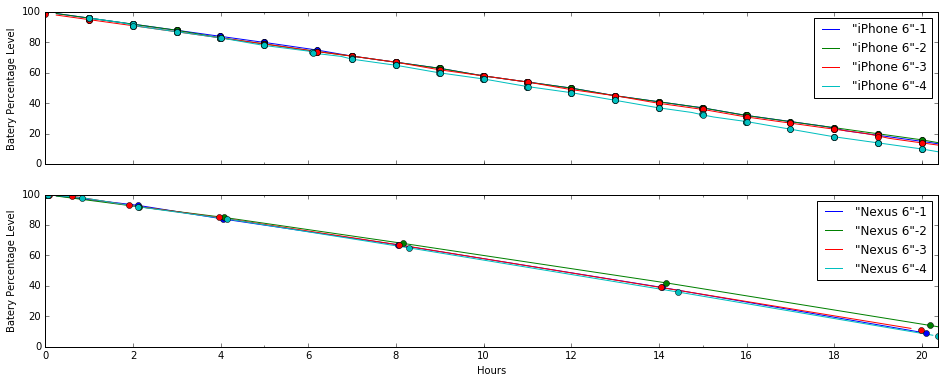

In [17]:
#Android + iOS combined 
(fig, axes2d) = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=True, figsize=(16,6))
axes = axes2d.flatten()


#iOS: With interplation on battery data 
for i, df in enumerate(iphone_battery_interp_df_list):
    #print "About to plot %d" % i
    df['hr'] = (df.ts-iphone_start_ts)/3600.0
    df.plot(x='hr', y='battery_level_pct', ax=axes[0], xlim=(0, 22), label="\"iPhone 6\"-%s" % (i+1), legend=True)

for i, df in enumerate(iphone_battery_df_list):
    #print "About to plot %d" % i
    df['hr'] = (df.ts-iphone_start_ts)/3600.0
    df.plot(x='hr', y='battery_level_pct', style=style[i], ax=axes[0], xlim=(0, 22), legend=False)
    axes[0].set_xlabel('Hours')
    axes[0].set_ylabel('Batery Percentage Level')
    plt.xticks(np.arange(0, 22, 2.0))
    
    
#Android: With interplation on battery data 
for i, df in enumerate(android_battery_interp_df_list):
    #print "About to plot %d" % i
    df['hr'] = (df.ts-android_start_ts)/3600.0
    df.plot(x='hr', y='battery_level_pct', ax=axes[1], xlim=(0, max(df.hr)), label="\"Nexus 6\"-%s" % (i+1), legend=True)


for i, df in enumerate(android_battery_df_list):
    #print "About to plot %d" % i
    df['hr'] = (df.ts-android_start_ts)/3600.0
    df.plot(x='hr', y='battery_level_pct', style=style[i], ax=axes[1], xlim=(0, max(df.hr)), legend=False)
    axes[1].set_xlabel('Hours')
    axes[1].set_ylabel('Batery Percentage Level')
    plt.xticks(np.arange(0, max(df['hr'])+1, 2))

fig.savefig('plots/sw_battery_drain.pdf')

In [15]:
#iphone data
for i, phone in enumerate(iphone_battery_df_list):
    batt = phone
    x = batt.metadata_write_ts
    y = batt.battery_level_pct

    p1 = np.polyfit(x,y,1)
    p2 = np.polyfit(x,y,2) # insufficient degree to include sqrt

    yfit1 = np.polyval(p1,x)
    yfit2 = np.polyval(p2,x)

    #plt.plot(x,y, label='data')
    #plt.plot(x,yfit1, label='fit')
    #plt.plot(x,yfit1-y, label='var')
    #plt.plot(x,yfit2, label='fit')
    #plt.plot(x,yfit2-y, label='var')

    
    print 'phone ' + str(i)
    print 'degree1: sum = ' + str(sum(abs(yfit1-y))) + ' avg = ' + str(sum(abs(yfit1-y))/len(y))
    print 'degree2: sum = ' + str(sum(abs(yfit2-y))) + ' avg = ' + str(sum(abs(yfit2-y))/len(y))

    print 'degree1: RMSE = ' + str(np.mean((y - yfit1) ** 2)**0.5)
    print 'degree2: RMSE = ' + str(np.mean((y - yfit2) ** 2)**0.5)
    print 

phone 0
degree1: sum = 25.8908444059 avg = 0.327732207669
degree2: sum = 19.0799300671 avg = 0.241518102115
degree1: RMSE = 0.392722774163
degree2: RMSE = 0.277507932936

phone 1
degree1: sum = 21.9586078646 avg = 0.285176725514
degree2: sum = 20.7842102051 avg = 0.269924807858
degree1: RMSE = 0.337272628766
degree2: RMSE = 0.318780709926

phone 2
degree1: sum = 34.1974998217 avg = 0.474965275301
degree2: sum = 22.8286838531 avg = 0.317065053516
degree1: RMSE = 0.569664338702
degree2: RMSE = 0.41075722165

phone 3
degree1: sum = 25.6632705778 avg = 0.346800953754
degree2: sum = 22.8537716866 avg = 0.308834752521
degree1: RMSE = 0.429902546252
degree2: RMSE = 0.36666102153



In [16]:
#android data
for i, phone in enumerate(android_battery_df_list):
    batt = phone
    x = batt.metadata_write_ts
    y = batt.battery_level_pct

    p1 = np.polyfit(x,y,1)
    p2 = np.polyfit(x,y,2) # insufficient degree to include sqrt

    yfit1 = np.polyval(p1,x)
    yfit2 = np.polyval(p2,x)

    #plt.plot(x,y, label='data')
    #plt.plot(x,yfit1, label='fit')
    #plt.plot(x,yfit1-y, label='var')
    #plt.plot(x,yfit2, label='fit')
    #plt.plot(x,yfit2-y, label='var')

    
    print 'phone ' + str(i)
    print 'degree1: sum = ' + str(sum(abs(yfit1-y))) + ' avg = ' + str(sum(abs(yfit1-y))/len(y))
    print 'degree2: sum = ' + str(sum(abs(yfit2-y))) + ' avg = ' + str(sum(abs(yfit2-y))/len(y))

    print 'degree1: RMSE = ' + str(np.mean((y - yfit1) ** 2)**0.5)
    print 'degree2: RMSE = ' + str(np.mean((y - yfit2) ** 2)**0.5)
    print 

phone 0
degree1: sum = 6.96140524955 avg = 1.16023420826
degree2: sum = 1.74069499969 avg = 0.290115833282
degree1: RMSE = 1.29929537095
degree2: RMSE = 0.392820044804

phone 1
degree1: sum = 8.02791803051 avg = 1.14684543293
degree2: sum = 1.07771587372 avg = 0.153959410531
degree1: RMSE = 1.2639092635
degree2: RMSE = 0.196099075514

phone 2
degree1: sum = 9.70882073999 avg = 0.882620067272
degree2: sum = 3.9533996582 avg = 0.359399968928
degree1: RMSE = 0.986047380195
degree2: RMSE = 0.431303867713

phone 3
degree1: sum = 9.32438862254 avg = 1.03604318028
degree2: sum = 3.6945772171 avg = 0.410508579678
degree1: RMSE = 1.12272760593
degree2: RMSE = 0.464603111453

